In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.definitions import _compute
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
import polars as pl
import dask.array as da
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Future som stuff

In [2]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
da_cesm = ds_cesm["s"].sel(time=ds_cesm.time.dt.season=="JJA")
dh = DataHandler(da_cesm, "/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results")
exp_s_cesm = Experiment(dh)

In [4]:
kwargs_som = dict(
    nx=6,
    ny=6,
    activation_distance="euclidean",
    PBC=True,
    init="pca",
    return_type=RAW_REALSPACE,
    sigma=2,
    sigmaN=0.1,
    dask_chunks=(500, -1),
    train_kwargs=dict(num_epochs=20),
)
net, centers, labels = exp_s_cesm.som_cluster(**kwargs_som)
nx, ny, metric = kwargs_som["nx"], kwargs_som["ny"], kwargs_som["activation_distance"]
ds_center_path = exp_s_cesm.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
ds_ = ds_cesm.sel(time=ds_cesm.time.dt.season=="JJA")
if not ds_center_path.is_file():
    ds_ = _compute(ds_, progress=True)
    ds_center = labels_to_centers(labels, ds_)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={**determine_sample_dims(ds_), "cluster": np.arange(net.n_nodes)})

## intransivity

In [93]:
labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
ny = labels_df["time"].dt.year().n_unique()
ne = labels_df["member"].n_unique()
labels_first_week = labels_df.filter(pl.col("time").dt.ordinal_day() < 161)
labels_JA = labels_df.filter(pl.col("time").dt.month().is_in([7, 8]))
labels_JA = labels_JA.with_columns(year=pl.col("time").dt.year())
vc = labels_first_week["labels"].value_counts(sort=True)

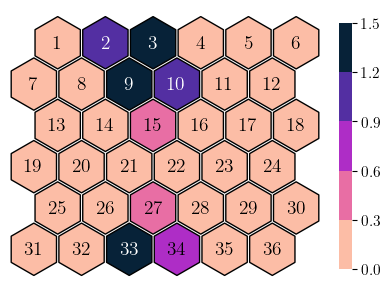

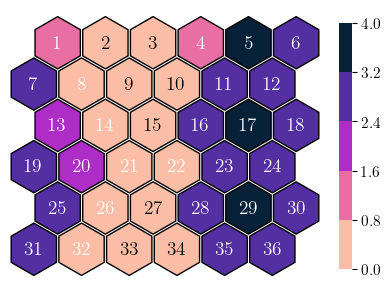

In [126]:
first_week_pops = labels_first_week["labels"].value_counts().sort("labels")
first_week_pops = first_week_pops.with_columns(pl.col("count") / ny / ne)
first_week_pops_values = np.zeros(net.x * net.y)
first_week_pops_values[first_week_pops["labels"]] = first_week_pops["count"]
cmap = colormaps.bubblegum_r
coords = net.neighborhoods.coordinates
fig, ax = net.plot_on_map(
    first_week_pops_values,
    smooth_sigma=0,
    show=True,
    cmap=cmap,
    norm=norm,
    discretify=True,
    draw_cbar=True,
)
for i, c in enumerate(coords):
    x, y = c
    color = "white" if first_week_pops_values[i] > 0.7 else "black"
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=14)
fig.savefig(f"{FIGURES}/future_som_props/intransivity_june_pop.png")
JA_pops = labels_JA["labels"].value_counts().sort("labels")
JA_pops = JA_pops.with_columns(pl.col("count") / ny / ne)
JA_pops_values = np.zeros(net.x * net.y)
JA_pops_values[JA_pops["labels"]] = JA_pops["count"]
fig, ax = net.plot_on_map(
    JA_pops_values,
    smooth_sigma=0,
    show=True,
    cmap=cmap,
    discretify=True,
    draw_cbar=True,
)
for i, c in enumerate(coords):
    x, y = c
    color = "white" if JA_pops_values[i] > 0.2 else "black"
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=14)
fig.savefig(f"{FIGURES}/future_som_props/intransivity_JA_pop.png")

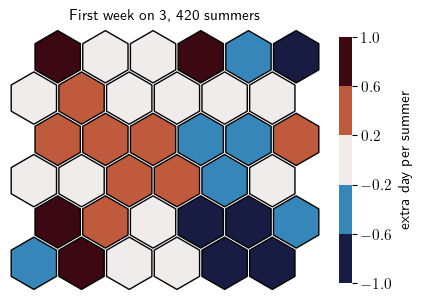

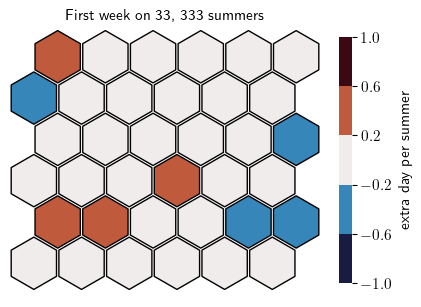

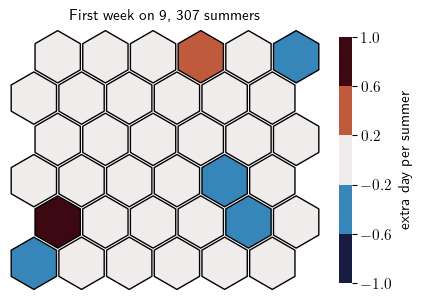

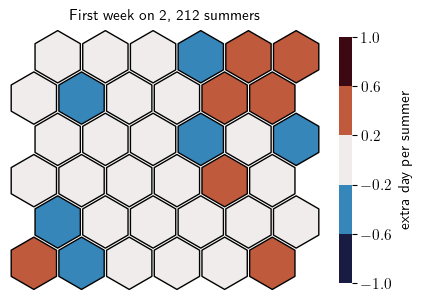

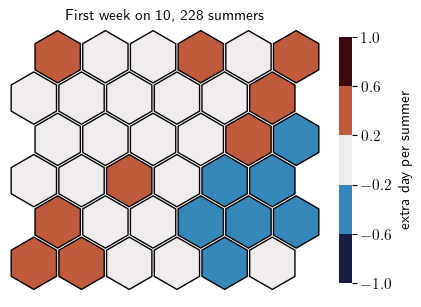

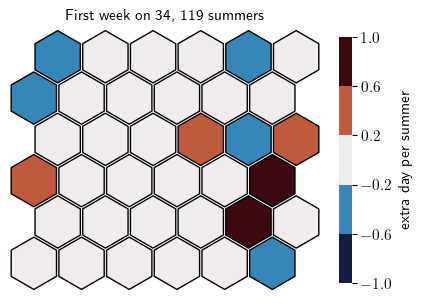

In [129]:
for i in range(6):
    june_winner = vc[i, "labels"]
    filter_ = (
        labels_first_week
        .group_by(["member", pl.col("time").dt.year()], maintain_order=True)
        .agg(
            proportion=(pl.col("labels") == june_winner).sum() / pl.col("labels").len()
        )
    )
    filter_ = filter_.filter(pl.col("proportion") > 0.5).rename({"time": "year"})
    ny_ = filter_["year"].n_unique()
    ne_ = filter_["member"].n_unique()
    filtered_JA = filter_.join(labels_JA, on=["member", "year"])
    filtered_JA = filtered_JA["labels"].value_counts().sort("labels")
    filtered_JA = filtered_JA.with_columns(pl.col("count") / filter_.shape[0])
    cmap = colormaps.balance
    norm = BoundaryNorm(np.arange(-1., 1.2, 0.4), cmap.N)
    filtered_JA_values = np.zeros(net.x * net.y)
    filtered_JA_values[filtered_JA["labels"]] = filtered_JA["count"]
    fig, ax = net.plot_on_map(
        filtered_JA_values - JA_pops_values,
        smooth_sigma=0,
        show=True,
        cmap=cmap,
        norm=norm,
        draw_cbar=True,
        cbar_label="extra day per summer",
    )
    ax.set_title(f"First week on {june_winner + 1}, {filter_.shape[0]} summers")
    fig.savefig(f"{FIGURES}/future_som_props/intransivity_{june_winner}.png")

## pathway

### overall

In [34]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    these_labels = labels.isel(time=group).values.flatten()
    coords = net.neighborhoods.coordinates[these_labels]
    unique, count = np.unique(these_labels, return_counts=True)
    
    timestepwise.append((unique, count))
    group = []

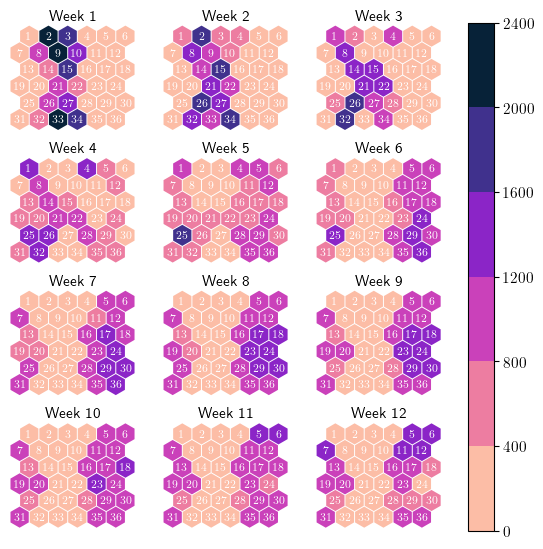

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.6), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 2401, 400), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][0], timestepwise[step][1]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/future_som_props/weekly_pathway.png")

### past

In [28]:
timestepwise = []
group = [] 
labels_past = labels.isel(time=labels.time.dt.year < 2020)
for i, (_, group_) in enumerate(labels_past.groupby(labels_past.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    these_labels = labels_past.isel(time=group).values.flatten()
    coords = net.neighborhoods.coordinates[these_labels]
    unique, count = np.unique(these_labels, return_counts=True)
    
    timestepwise.append((unique, count))
    group = []

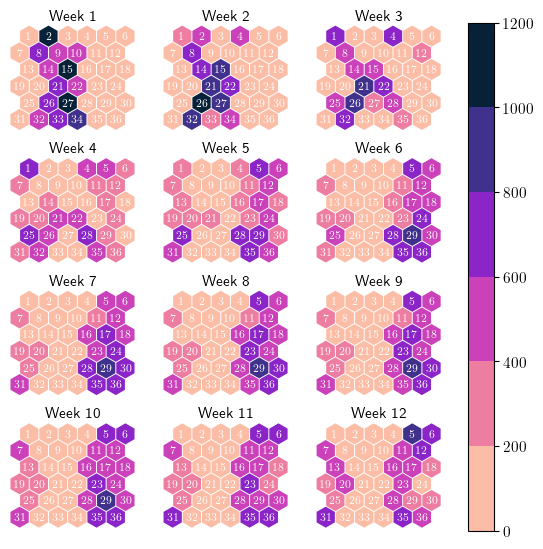

In [31]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.6), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 1201, 200), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][0], timestepwise[step][1]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/future_som_props/weekly_pathway_past.png")

### future

In [36]:
timestepwise = []
group = [] 
labels_future = labels.isel(time=labels.time.dt.year >= 2020)
for i, (_, group_) in enumerate(labels_future.groupby(labels_future.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    these_labels = labels_future.isel(time=group).values.flatten()
    coords = net.neighborhoods.coordinates[these_labels]
    unique, count = np.unique(these_labels, return_counts=True)
    
    timestepwise.append((unique, count))
    group = []

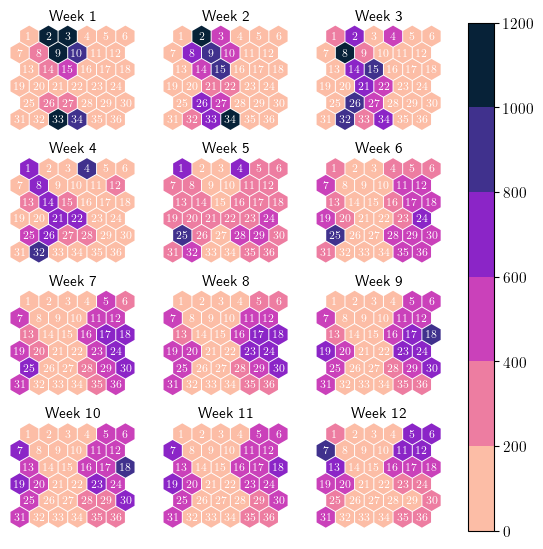

In [37]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.6), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 1201, 200), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][0], timestepwise[step][1]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/future_som_props/weekly_pathway_future.png")

## pops, trends

# Explicit SOM

In [ ]:
import dask
import time
net._init_weights(X)
net._sq_weights_gpu = None
weights = net.weights
feature_dims = exp_s_cesm.data_handler.get_feature_dims()
we = centers_realspace(net.weights, feature_dims)
clu = Clusterplot(kwargs_som["y"], kwargs_som["x"], honeycomb=True, region=get_region(exp_s_cesm.da))
_ = clu.add_contourf(we, cmap=colormaps.matter, levels=7, transparify=1)
display(clu.fig)
time.sleep(1)
num_epochs = 50
for iteration in range(num_epochs):
    try:  # reuse already allocated memory
        numerator.fill(0)
        denominator.fill(0)
    except (UnboundLocalError, NameError):  # whoops, I haven't allocated it yet
        numerator = np.zeros(weights.shape, dtype=np.float32)
        denominator = np.zeros(
            weights.shape, dtype=np.float32
        )
    net._update_rates(iteration, num_epochs)
    
    blocks = data_block.to_delayed().ravel()
    numerator_array = []
    denominator_array = []
    for block in blocks:
        a, b = dask.delayed(net._update, nout=2)(block, weights)
        numerator_array.append(a)
        denominator_array.append(b)
    numerator_sum = dask.delayed(sum)(numerator_array)
    denominator_sum = dask.delayed(sum)(denominator_array)
    numerator, denominator = dask.compute(
        numerator_sum, denominator_sum
    )
    weights = net._merge_updates(
        weights, numerator, denominator
    )
    # weights = (
    #     1 - net.learning_rate
    # ) * weights + net.learning_rate * new_weights
    weights = weights.astype(np.float32)
    net.weights = weights
    
    if iteration % 10 == 0:
        if clu:
            plt.close(clu.fig)
            del clu
            clear_output(wait = True)
        we = centers_realspace(weights, feature_dims)
        clu = Clusterplot(kwargs_som["y"], kwargs_som["x"], honeycomb=True, region=get_region(exp_s_cesm.da))
        _ = clu.add_contourf(we, cmap=colormaps.matter, levels=7, transparify=1)
        display(clu.fig)    
    print(f'ite: {iteration + 1}/{num_epochs}, lr: {net.learning_rate:.2e}, sigma: {net.sigma:.2e}', end='\r')

In [35]:
net.topographic_error(X)

0.34385906536527655

In [36]:
dask.compute(net.quantization_error(X))

(69.76447,)

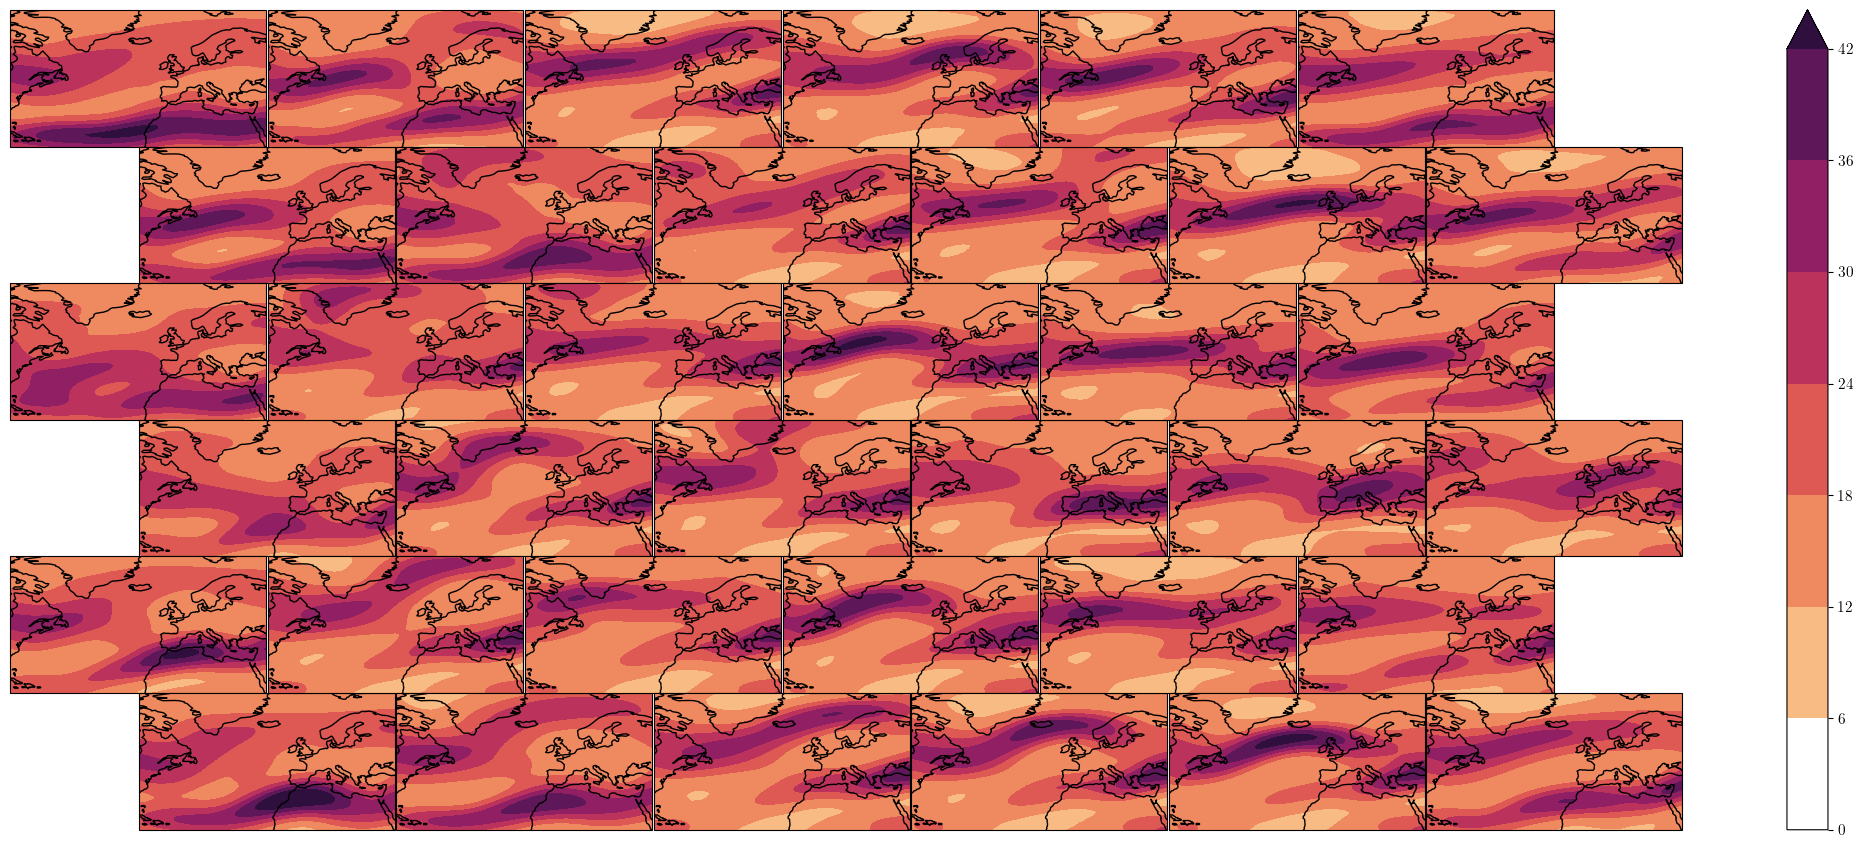

In [25]:
clu = Clusterplot(kwargs_som["y"], kwargs_som["x"], honeycomb=True, region=get_region(exp_s_cesm.da))
_ = clu.add_contourf(centers, cmap=colormaps.matter, levels=7, transparify=1)